# Temperature Background

In [1]:
# Imports
from PIL import Image
from meteostat import Point, Daily

import datetime as dt
import numpy as np
import pandas as pd

In [2]:
# Variables

# Time period for data
start = dt.datetime(1950, 1, 1)
end = dt.datetime.now()

# Weather station. Location taken from: https://github.com/meteostat/weather-stations/search?q=berlin
berlin = Point(52.4667, 13.4, 50)
munich = Point(48.1333, 11.55, 520)

# colour scale
scale = {}

In [3]:
# Functions

def df_to_list(df):
    ls = df.values.tolist()
    return ls


def df_to_pv(df, value):
    df = df.pivot(index="year", columns="day", values=value)
    df = df.dropna(how="any")
    return df   


def get_data(location):
    data = Daily(location, start, end)
    df = data.fetch()
    df.to_excel('RawData.xlsx')
    return df


def group_data(df, value):
    df["year"] = df["time"].dt.year
    df = df.drop(columns=["time"], axis=1)
    df["count"] = 1
    df = df.dropna()
    df = df.groupby(["year"]) \
            .agg({value:'mean', 'count':'sum'}) \
            .reset_index()
    df = df.loc[df["count"] >= 356]
    df = df.drop(columns=["count"], axis=1)
    return df


def ls_to_image(ls):
    array = np.array(ls, dtype=np.uint8)
    image = Image.fromarray(array)
    return image


def repeat_rows(df, reps):
    df = pd.DataFrame(np.repeat(df.values, reps, axis=0))
    return df


def select_rel_data(df, value):
    df = df.reset_index()
    coloumns = ["time", str(value)]
    df = df[coloumns]
    df = df.sort_values(by="time", ascending=True)
    return df


def set_colour(d, keys, value):
    for k in keys:
        d[k] = value


def set_scale(df):
    min = round(df.min().min())
    max = round(df.max().max()) + 1
    diff = max - min
    set_colour(scale, range(int(min), int(min + diff * 1/8)), [230, 234, 233])
    set_colour(scale, range(int(min + diff * 1/8), int(min + diff * 2/8)), [209, 219, 225])
    set_colour(scale, range(int(min + diff * 2/8), int(min + diff * 3/8)), [218, 220, 223])
    set_colour(scale, range(int(min + diff * 3/8), int(min + diff * 4/8)), [199, 189, 194])
    set_colour(scale, range(int(min + diff * 4/8), int(min + diff * 5/8)), [179, 173, 178])
    set_colour(scale, range(int(min + diff * 5/8), int(min + diff * 6/8)), [161, 154, 158])
    set_colour(scale, range(int(min + diff * 6/8), int(min + diff * 7/8)), [136, 117, 123])
    set_colour(scale, range(int(min + diff * 7/8), int(min + diff)), [96, 79, 91])
    return scale


def temp_to_pixel(ls):
    for x in range(0, len(ls)):
        for y in range(0, len(ls[x])):
            ls[x][y] = np.round(ls[x][y])
            ls[x][y] = scale[ls[x][y]]
    return ls


def transform_columns(df):
    df["date"] = pd.to_datetime(df["time"])
    df["year"] = df["date"].dt.year
    df["day"] = df["date"].dt.day_of_year
    # exclude day 366 for leap years
    df = df[(df["day"] <= 365)]
    return df


def transform_data(df, value):
    df[value] = df[value] * 10
    df[value] = df[value].astype(int)
    return df


def transpose_data(df):
    df = df.drop(columns=["year"], axis=0)
    df = df.T
    return df

## Create & show final image

In [4]:
def horizonral_image(name, location, value, reps):
    df = get_data(location)
    df = select_rel_data(df, value)
    df = group_data(df, value)
    df = transform_data(df, value)
    df = transpose_data(df)
    df = repeat_rows(df, reps)
    ls = df_to_list(df)
    scale = set_scale(df)
    ls = temp_to_pixel(ls)
    image = ls_to_image(ls)
    image.save(name + ".png")
    return image


def pixel_image(name, location, value, reps):
    df = get_data(location)
    df = select_rel_data(df, value)
    df = transform_columns(df)
    df = df_to_pv(df, value)
    df = repeat_rows(df, reps)
    ls = df_to_list(df)
    scale = set_scale(df)
    ls = temp_to_pixel(ls)
    image = ls_to_image(ls)
    image.save(name + ".png")
    return image


In [5]:
horizontal_background = horizonral_image(name = 'horizontal_image', location = munich, value = "tmax", reps = 50)


In [6]:
pixel_background = pixel_image(name= "pixel_image", location = munich, value = "tmin", reps = 3)

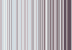

In [7]:
horizontal_background

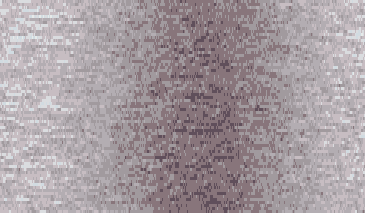

In [8]:
pixel_background